In [22]:
import pandas as pd
from sklearn.cluster import KMeans
import json
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv("final_data.csv")


In [3]:
#get artist embedding dict

with open("500_artist_embeddings.json", "r") as file:
    artist_embeddings = json.load(file)

artist_names = list(artist_embeddings.keys())
embedding_values = list(artist_embeddings.values())
embedding_array = np.array(embedding_values)
len(embedding_values)

495

c:\Users\decla\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


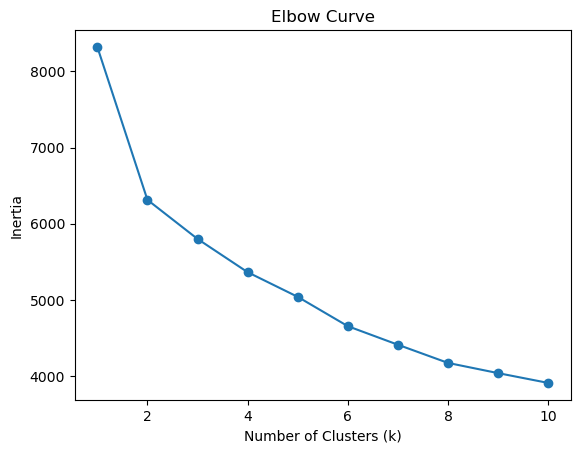

In [4]:
#use elbow method to find optimal number of clusters

inertia_values = []

# Try different values of k
k_values = range(1, 11)
for k in k_values:
    # Create a KMeans instance with the current k value
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the k-means model to the vectors
    kmeans.fit(embedding_array)
    
    # Append the inertia value to the list
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()


Im going to choose K = 4, after some experimentation below. There are actually ~8 different genres in the dataset, (9, but acid rock is very small), however the genres from wikipedia are not super well defined so I expect a good amount of overlap. I think another trial using more data will yield more distinct clusters.

In [5]:
#fit k=4 model and get cluster predictions for each of the training vectors

model = KMeans(n_clusters=4, random_state=42).fit(embedding_array)

preds = model.predict(embedding_array)

#for each artist, get their genre, and create a dict mapping clusters, to a list of artists, and genres
cluster_to_artists = dict()
cluster_to_genre = dict()
for i,c in enumerate(preds):
    
    name = artist_names[i]
    genre = df.loc[df["artist"] == name, "genre"].values[0]


    if c in cluster_to_artists:
        cluster_to_artists[c].append(name)
    else:
        cluster_to_artists[c] = [name]
    
    if c in cluster_to_genre:
        cluster_to_genre[c].append(genre)
    else:
        cluster_to_genre[c] = [genre]





Class 3: {'punk': 0.0875, 'emo': 0.15625, 'dream pop': 0.09375, 'dance pop': 0.134375, 'hip hop': 0.01875, 'acid rock': 0.025, 'hard rock': 0.05625, 'country': 0.078125, 'adult alternative': 0.35}
Class 1: {'punk': 0.1, 'emo': 0.05, 'dance pop': 0.225, 'hip hop': 0.4, 'hard rock': 0.05, 'dream pop': 0.075, 'adult alternative': 0.1}
Class 0: {'punk': 0.05714285714285714, 'emo': 0.047619047619047616, 'dream pop': 0.009523809523809525, 'dance pop': 0.047619047619047616, 'hip hop': 0.6571428571428571, 'hard rock': 0.009523809523809525, 'country': 0.06666666666666667, 'adult alternative': 0.10476190476190476}
Class 2: {'punk': 0.03333333333333333, 'emo': 0.03333333333333333, 'dance pop': 0.06666666666666667, 'hip hop': 0.8333333333333334, 'adult alternative': 0.03333333333333333}


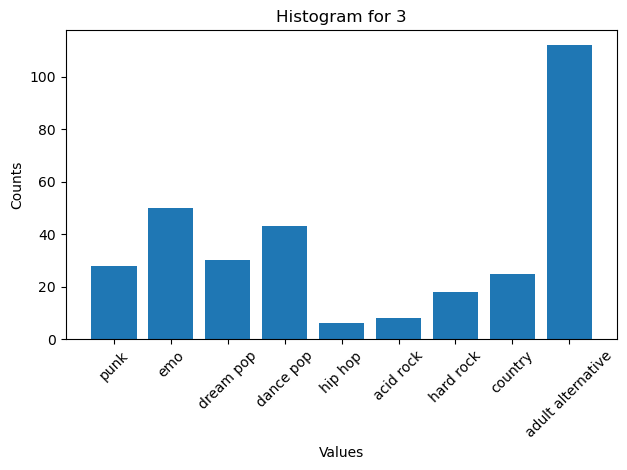

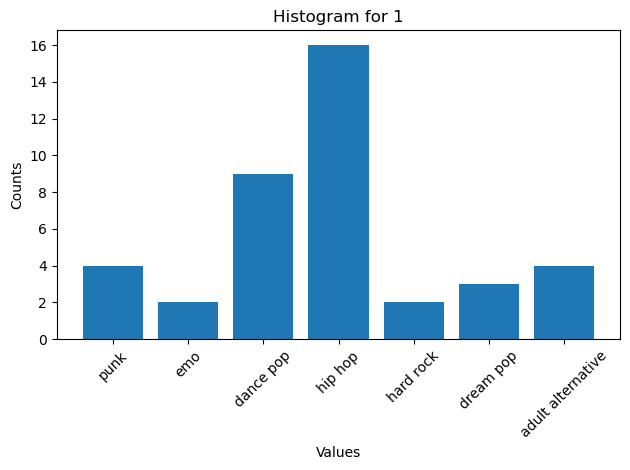

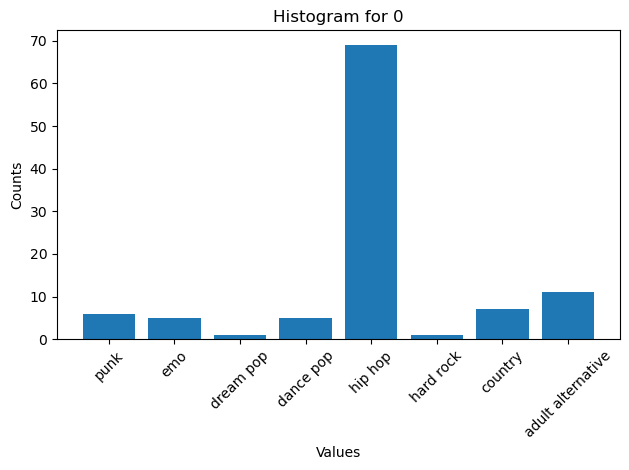

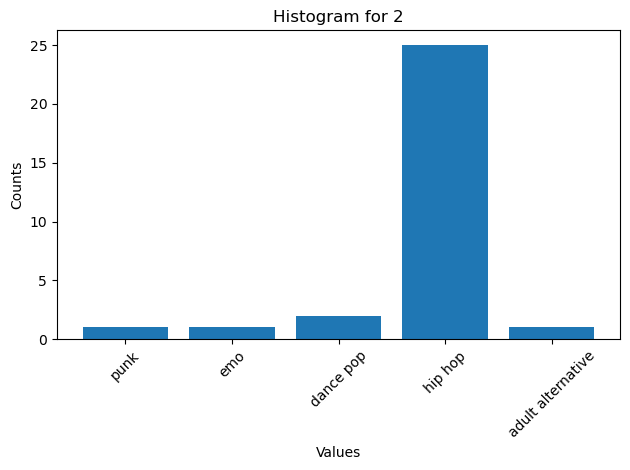

In [47]:
import matplotlib.pyplot as plt



# Iterate over each cluster in the dictionary
for class_name, values in cluster_to_genre.items():
    # Count the occurrences of each value in the list
    value_counts = {value: values.count(value) for value in set(values)}

    #get percentage of each genre in each cluster
    class_percentages = {}

    for key, val in value_counts.items():
        p = val / sum(list(value_counts.values()))
        class_percentages[key] = p
    print(f"Class {class_name}: {class_percentages}")


    
    # Extract the unique values and their counts
    unique_values = list(value_counts.keys())
    counts = list(value_counts.values())
    
    # Create a new figure for each histogram
    plt.figure()
    
    # Plot the histogram
    plt.bar(unique_values, counts)
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.title(f'Histogram for {class_name}')
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    
    # Adjust the layout to prevent overlapping labels
    plt.tight_layout()

# Display all the histograms
plt.show()


As you can see for this small trial of 500 artists, a simple k-means is pretty good at distinguishing hip-hop artists from the other genres. The clusters mix together the other genres a bit, but this makes sense as adult alternative is basically a mix of many genres, and has the most datapoints. I think with more data, and better defined genres it will be easier to cluster these artists. But I think these are promising results given this is completely unsupervised, only based on lyrics, and with limited data. Also interestingly, cluster 2 despite having mostly hop-hop, is mostly latin music artists, which is cool since this BERT model was trained on an english corpus, yet the embeddings extracted information from spanish being in the lyrics. This indicated that this method may also be useful in language classifcation tasks.

In [34]:
from numpy import dot
from numpy.linalg import norm

#function to find 10 closest artists given an artist

def x_closest(artist_name, embedding_dict, x=10):

    emb = embedding_dict[artist_name]

    #[(artistname,embedding)]
    emb_tuples = list(artist_embeddings.items())
    
    #remove artist_name from that list
    emb_tuples = list(filter(lambda t: t[0] != artist_name, emb_tuples))

    similarity_list = []

    for t in emb_tuples:


        cosine_sim = dot(emb,t[1]) / (norm(emb) * norm(t[1]))
        similarity_list.append((t[0], cosine_sim))

    similarity_list.sort(key=lambda tup: tup[1], reverse=True)

    return similarity_list[0:x]



In [48]:
#lets see some similar artists in hip-hop

print(cluster_to_artists[1])
print(cluster_to_genre[1])

['Art Attacks', 'Discharge', 'Nina Hagen', 'The Zeros', 'Cream', 'Devo', 'Freddy Fresh', 'Kraftwerk', 'Amy Lee', 'Dan Snaith', 'Company B', 'Da Pump', 'Five', 'Pizzicato Five', 'Seiko Matsuda', 'Steps', 'Stock Aitken Waterman', 'Therese Grankvist', 'Grimes', 'Parannoul', 'Plastic Flowers', 'Falling Up', 'Gwen Stacy', 'The Four Horsemen', 'Asterix', '12 Gauge', 'Beans', 'Ryan Celsius', 'Snow', 'Coke La Rock', 'Tha City Paper', 'Jack Parow', 'Rick Rock', 'Chinko Ekun', 'Abbas Kubaff', 'Opio', 'Giant Pink', 'DJ Khalil', 'Teddy Walton', 'Sho Madjozi']
['punk', 'punk', 'punk', 'punk', 'hip hop', 'adult alternative', 'adult alternative', 'adult alternative', 'adult alternative', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dance pop', 'dream pop', 'dream pop', 'dream pop', 'emo', 'emo', 'hard rock', 'hard rock', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', 'hip hop', '

In [44]:
print(x_closest("Shakira", artist_embeddings, 8))
print(x_closest("Bob Dylan", artist_embeddings, 8))
print(x_closest("Katy Perry", artist_embeddings, 8))

[('The Black Eyed Peas', 0.9695859368872788), ('Kali', 0.9495440662733231), ('Morad', 0.9481285339596104), ('Anuel AA', 0.9431987542302789), ('Les Luthiers', 0.9384303198142798), ('Agus Padilla', 0.9354280218840648), ('Alemán', 0.9326028500916597), ('Skillz', 0.9280810680758181)]
[('Blue Öyster Cult', 0.9840474427188224), ('Counting Crows', 0.9826016815713379), ('Jeremy Fisher', 0.9816424899570926), ('Graham Bonnet', 0.9815471238737207), ('The Clash', 0.9802952171539981), ('Slaine', 0.9801416644765404), ('Eric Church', 0.9800029242380097), ('Johnny Cash', 0.9799051492141652)]
[('Fall Out Boy', 0.9870159964569103), ('Lorde', 0.9867889656981296), ('Panic! At The Disco', 0.9861922331135863), ('Panic! at the Disco', 0.9861922331135863), ('070 Shake', 0.9850855873204307), ('Bastille', 0.9834918439662366), ('Glass Animals', 0.9829904560386173), ('Smash Mouth', 0.9828949666571198)]


I have no cluse how 'Panic! At The Disco' is in there twice considering all these artist names were keys in a dictionary, and there cant be dupilcate keys, so im just not gonna worry about it.
Overall though, these results look pretty good!